# Modeling - ethereum - v2

# Setup

## Library import
We import all the required Python libraries

In [1]:
import os

# Data manipulation
from feature_engine.encoding import RareLabelEncoder, CountFrequencyEncoder
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np

# Visualizations
import plotly
import plotly.graph_objs as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
import missingno as msno
from pycaret.classification import ClassificationExperiment
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, GridSearchCV, HalvingGridSearchCV, cross_validate
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import set_config

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

# Options for pandas
set_config(transform_output = "pandas")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.5f}'.format)
# pd.options.display.float_format = '{:.5f}'.format
# pd.options.display.max_rows = 120

sns.set_context(context='paper', font_scale=1, rc=None)
sns.set_style("ticks")
sns.set_palette(sns.color_palette())

## Local library import
We import all the required local libraries libraries

In [2]:
os.chdir('../')
from src.utils.data_describe import breve_descricao, serie_nulos, cardinalidade, check_for_equal_columns
os.chdir('./notebooks/')

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [3]:
RAW_FOLDER = '../data/raw/'
INTERIM_FOLDER = '../data/interim/'
PROCESSED_FOLDER = '../data/processed/'
REPORTS_FOLDER = '../reports/'
RANDOM_STATE = 42

train_size = 0.15

# Experience 01 - Only numerical attributes

## Data import

In [4]:
df_train_exp_01 = pd.read_parquet(INTERIM_FOLDER + 'df_train_exp_01.pqt')
df_test_exp_01 = pd.read_parquet(INTERIM_FOLDER + 'df_test_exp_01.pqt')

display(df_train_exp_01.head(3))

,Address,FLAG,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,max_value_received,avg_val_received,min_val_sent,max_val_sent,avg_val_sent,total_transactions_(including_tnx_to_create_contract),total_Ether_sent,total_ether_received,total_ether_balance,Total_ERC20_tnxs,ERC20_total_Ether_received,ERC20_total_ether_sent,ERC20_total_Ether_sent_contract,ERC20_uniq_sent_addr,ERC20_uniq_rec_addr,ERC20_uniq_rec_contract_addr,ERC20_avg_time_between_contract_tnx,ERC20_min_val_rec,ERC20_max_val_rec,ERC20_avg_val_rec,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name
0,0x0020731604c882cf7bf8c444be97d17b19ea4316,1,1457.31000,34.12000,4815.43000,3,13,0,10,3,1.00000,2.50105,1.34844,1.00087,11.27787,5.84292,16,17.52875,17.52978,0.00104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0x002bf459dc58584d58886169ea0e80f3ca95ffaf,1,3976.50000,834.77000,9622.53000,2,2,0,1,2,0.58627,0.94751,0.76689,0.58541,0.94728,0.76635,4,1.53269,1.53378,0.00109,1.00000,1.33700,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,1.33700,1.33700,1.33700,0.00000,0.00000,0.00000,0.00000,1.00000
2,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,1,112.90000,31.87000,321.42000,2,3,0,3,1,0.00102,0.81780,0.43961,0.50039,0.81751,0.65895,5,1.31790,1.31882,0.00092,1.00000,1.33700,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,1.33700,1.33700,1.33700,0.00000,0.00000,0.00000,0.00000,1.00000


# Light Gradient Boosting - Categorical features encoded by frequency

## Data import

In [5]:
df_raw = pd.read_parquet(INTERIM_FOLDER + 'ethereum_complete.pqt')

df_train_exp_02 = pd.read_parquet(INTERIM_FOLDER + 'df_cleaned_train_exp_02_transformed.pqt')
df_test_exp_02 = pd.read_parquet(INTERIM_FOLDER + 'df_cleaned_test_exp_02_transformed.pqt')

X_train_exp_02 = df_train_exp_02.drop(columns=['FLAG'])
y_train_exp_02 = df_train_exp_02[['FLAG']]

X_test_exp_02 = df_test_exp_02.drop(columns=['FLAG'])
y_test_exp_02 = df_test_exp_02[['FLAG']]

display(X_train_exp_02.head(3))

,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,max_value_received,avg_val_received,min_val_sent,max_val_sent,avg_val_sent,total_transactions_(including_tnx_to_create_contract),total_Ether_sent,total_ether_received,total_ether_balance,Total_ERC20_tnxs,ERC20_total_Ether_received,ERC20_total_ether_sent,ERC20_total_Ether_sent_contract,ERC20_uniq_sent_addr,ERC20_uniq_rec_addr,ERC20_uniq_rec_contract_addr,ERC20_avg_time_between_contract_tnx,ERC20_min_val_rec,ERC20_max_val_rec,ERC20_avg_val_rec,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name,ERC20_most_sent_token_type,ERC20_most_rec_token_type
3691,67691.12000,0.00000,135382.23000,2,1,0,1,2,0.70927,0.70927,0.70927,0.10700,0.29554,0.20127,3,0.40254,0.70927,0.30673,7.00000,139.77633,0.00000,0.00000,0.00000,5.00000,7.00000,0.00000,0.00000,77.37208,19.96805,0.00000,0.00000,0.00000,0.00000,7.00000,0.89006,0.31874
152,23488.73000,33.36000,48178.53000,2,36,0,26,2,0.01038,9.99000,1.33005,0.07579,48.30435,24.19007,38,48.38014,47.88187,-0.49828,2.00000,1.33700,0.00000,0.00000,0.00000,2.00000,2.00000,0.00000,0.00000,1.33700,0.66850,0.00000,0.00000,0.00000,0.00000,2.00000,0.89006,0.16704
1175,0.00000,0.00000,0.00000,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0.00000,0.00000,0.00000,1.00000,1.33700,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,1.33700,0.86644,0.00000,0.00000,0.00000,0.00000,1.00000,0.89006,0.51421


## Random search

In [6]:
classifier_lgbm = LGBMClassifier(
    random_state=RANDOM_STATE, n_jobs=-1, silent = 'warn', objective = 'binary', importance_type = 'split',
)

#     boosting_type = ['gbdt', 'dart', 'rf'],
dct_params = dict(
    num_leaves = [int(31*.75), 31, int(31*1.25)],
    max_depth = np.arange(4, 36, 4).tolist(),
    learning_rate = [0.01, 0.05, 0.1],
    n_estimators = np.arange(50, 600, 150).tolist(),
)


# params = dict(
#     n_estimators=np.arange(50, 600, 150).tolist(),
#     criterion=['gini', 'entropy', 'log_loss'],
#     max_depth=np.arange(4, 36, 4).tolist(),
#     max_features=['sqrt', 'log2'],
#     ccp_alpha=np.arange(0, 0.035, 0.005).tolist(),
# )

rscv = RandomizedSearchCV(
    classifier_lgbm, dct_params, error_score='raise', random_state=RANDOM_STATE, n_iter=100,
    return_train_score=True, scoring='roc_auc', cv=10
)

search = rscv.fit(X_train_exp_02, y_train_exp_02)

best_rscv = search.best_params_
best_rscv

{'num_leaves': 31, 'n_estimators': 500, 'max_depth': 20, 'learning_rate': 0.05}

## Grid search

In [24]:
classifier_lgbm = LGBMClassifier(
    random_state=RANDOM_STATE, n_jobs=-1, silent = 'warn', objective = 'binary', importance_type = 'split',
)

dct_params = dict(
    max_depth=[18, 19, 20, 21, 22],
    num_leaves=[29, 31, 33],
    learning_rate=[0.025, 0.05]
)

display(dct_params)

{'max_depth': [18, 19, 20, 21, 22],
 'num_leaves': [29, 31, 33],
 'learning_rate': [0.025, 0.05]}

In [27]:
gscv = GridSearchCV(
    classifier_lgbm, dct_params, error_score='raise',
    return_train_score=True, scoring='roc_auc', cv=10, n_jobs=-1
)

grid_search = gscv.fit(X_train_exp_02, y_train_exp_02)
best_gscv = grid_search.best_params_
best_gscv

{'learning_rate': 0.05, 'max_depth': 18, 'num_leaves': 29}

## AUC vs n_estimators vs depth - ESTOU NESSE PONTO

- 10-fold cross validation

In [26]:
X_exp_02 = pd.concat([X_train_exp_02, X_test_exp_02], axis=0)
y_exp_02 = pd.concat([y_train_exp_02, y_test_exp_02], axis=0)

In [29]:
best_params = dict(
    random_state=RANDOM_STATE, n_jobs=-1, silent='warn', objective='binary', importance_type='split',
    learning_rate=0.05, num_leaves=29
)

In [30]:
scoring='roc_auc'
dct_results = {}

for n_estimator in np.arange(100, 1000, 25).tolist():
# for n_estimator in [100]:
    for depth in [3, 6, 9, 12, 15, 18]:
        classifier_lgbm = LGBMClassifier(
            **best_params, n_estimators=n_estimator, max_depth=depth
        )

        cross = cross_validate(
            estimator=classifier_lgbm, X=X_exp_02, y=y_exp_02, scoring=scoring, cv=10,
            n_jobs=-1, verbose=0, return_train_score=True, 
        )

        dct_results[str(n_estimator)+'_'+str(depth)] = {
            'n_estimator': n_estimator,
            'depth': depth,
            'test_score_mean': cross['test_score'].mean(),
            'test_score_std': cross['test_score'].std(),
            'train_score_mean': cross['train_score'].mean(),
            'train_score_std': cross['train_score'].std(),
        }

df_results = pd.DataFrame.from_dict(dct_results, orient='index')
df_results.head()

,n_estimator,depth,test_score_mean,test_score_std,train_score_mean,train_score_std
100_3,100,3,0.99786,0.00090,0.99879,0.00006
100_6,100,6,0.99842,0.00066,0.99990,0.00002
100_9,100,9,0.99861,0.00058,1.00000,0.00000
100_12,100,12,0.99858,0.00059,1.00000,0.00000
100_15,100,15,0.99859,0.00056,1.00000,0.00000


In [33]:
df_results['test_score_mean'].min()

0.9978634781632765

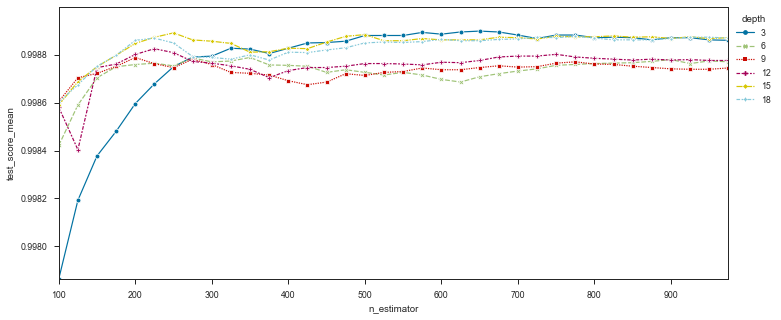

In [53]:
plt.figure(figsize=(12, 5))

ax = sns.lineplot(
    data=df_results, x='n_estimator', y='test_score_mean', hue='depth', palette=sns.color_palette(),
    style="depth", markers=True
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(100, df_results['n_estimator'].max())
ax.set_ylim(df_results['test_score_mean'].min(), df_results['test_score_mean'].max()*1.0001);

## Log loss vs iterations vs train-test

In [54]:
lst_iterations = np.arange(0, 326, 1).tolist()
lst_iterations[0] = 1

In [55]:
scoring='neg_log_loss'
dct_results = {}
depth = 6
n_estimator = 450


for n_estimator in lst_iterations:
    classifier_lgbm = LGBMClassifier(
            **best_params, n_estimators=n_estimator, max_depth=depth
        )
    
    cross = cross_validate(
        estimator=classifier_lgbm, X=X_exp_02, y=y_exp_02, scoring=scoring, cv=10,
        n_jobs=-1, verbose=0, return_train_score=True, 
    )

    dct_results[str(n_estimator)+'_'+str(depth)] = {
        'n_estimator': n_estimator,
        'test_score_mean': abs(cross['test_score'].mean()),
        'test_score_std': cross['test_score'].std(),
        'train_score_mean': abs(cross['train_score'].mean()),
        'train_score_std': cross['train_score'].std(),
    }

df_results = pd.DataFrame.from_dict(dct_results, orient='index')
df_results.head()

,n_estimator,test_score_mean,test_score_std,train_score_mean,train_score_std
1_6,1,0.64834,0.00068,0.64755,0.00030
2_6,2,0.61002,0.00133,0.60850,0.00055
3_6,3,0.57478,0.00200,0.57266,0.00059
4_6,4,0.54263,0.00279,0.53973,0.00062
5_6,5,0.51320,0.00332,0.50943,0.00052


In [62]:
df_results_melted = df_results[
    ['n_estimator','test_score_mean','train_score_mean']
].melt(['n_estimator'], var_name='scores', value_name='mean')

df_results_melted.sample(3, random_state=RANDOM_STATE)

,n_estimator,scores,mean
637,313,train_score_mean,0.00158
220,221,test_score_mean,0.04362
428,104,train_score_mean,0.02580


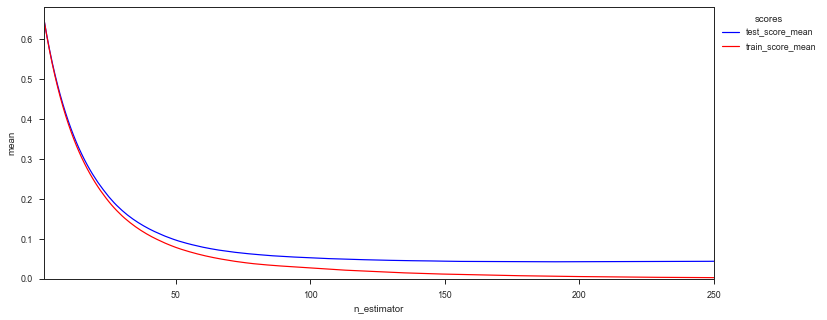

In [66]:
plt.figure(figsize=(12, 5))

ax = sns.lineplot(
    data=df_results_melted, x='n_estimator', y='mean', hue='scores', palette=['blue', 'red']
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(min(lst_iterations), 250)
ax.set_ylim(0, df_results_melted['mean'].max()*1.05);

In [64]:
df_results.sort_values(by=['test_score_mean'], ascending=False)

,n_estimator,test_score_mean,test_score_std,train_score_mean,train_score_std
1_6,1,0.64834,0.00068,0.64755,0.00030
2_6,2,0.61002,0.00133,0.60850,0.00055
3_6,3,0.57478,0.00200,0.57266,0.00059
4_6,4,0.54263,0.00279,0.53973,0.00062
5_6,5,0.51320,0.00332,0.50943,0.00052
...,...,...,...,...,...
181_6,181,0.04317,0.01111,0.00790,0.00039
198_6,198,0.04317,0.01161,0.00628,0.00036
192_6,192,0.04316,0.01126,0.00680,0.00034
193_6,193,0.04315,0.01131,0.00669,0.00035


# Random forest - Categorical features encoded by frequency

## Data import

In [ ]:
df_train_exp_02 = pd.read_parquet(INTERIM_FOLDER + 'df_train_exp_02.pqt')
df_test_exp_02 = pd.read_parquet(INTERIM_FOLDER + 'df_test_exp_02.pqt')

X_train_exp_02 = df_train_exp_02.drop(columns=['Address', 'FLAG'])
y_train_exp_02 = df_train_exp_02[['FLAG']]

X_test_exp_02 = df_test_exp_02.drop(columns=['Address', 'FLAG'])
y_test_exp_02 = df_test_exp_02[['FLAG']]

display(X_train_exp_02.head(3))

## Random search

In [ ]:
classifier_rf = RandomForestClassifier(
    random_state=RANDOM_STATE, n_jobs=-1, verbose=0
)

params = dict(
    n_estimators=np.arange(50, 600, 150).tolist(),
    criterion=['gini', 'entropy', 'log_loss'],
    max_depth=np.arange(4, 36, 4).tolist(),
    max_features=['sqrt', 'log2'],
    ccp_alpha=np.arange(0, 0.035, 0.005).tolist(),
)

rscv = RandomizedSearchCV(
    classifier_rf, params, error_score='raise', random_state=RANDOM_STATE, n_iter=100,
    return_train_score=True, scoring='roc_auc', cv=10
)

search = rscv.fit(X_train_exp_02, y_train_exp_02)
search.best_params_

In [ ]:
best_rscv = search.best_params_

## Grid search

In [ ]:
np.arange(int(best_rscv['max_depth']*.9), int(best_rscv['max_depth']*1.1), 1)

In [ ]:
classifier_rf = RandomForestClassifier(
    random_state=RANDOM_STATE, n_jobs=-1, verbose=0, **best_rscv
)

params = dict(
    n_estimators=np.arange(int(best_rscv['n_estimators']*.9), int(best_rscv['n_estimators']*1.1), 25).tolist(),
    max_depth=np.arange(int(best_rscv['max_depth']*.9), int(best_rscv['max_depth']*1.1), 1)
)

gscv = GridSearchCV(
    classifier_rf, params, error_score='raise',
    return_train_score=True, scoring='roc_auc', cv=10
)

grid_search = gscv.fit(X_train_exp_02, y_train_exp_02)
grid_search.best_params_

## AUC vs n_estimators vs depth

- 10-fold cross validation

In [ ]:
X_exp_02 = pd.concat([X_train_exp_02, X_test_exp_02], axis=0)
y_exp_02 = pd.concat([y_train_exp_02, y_test_exp_02], axis=0)

In [ ]:
best_params = {
    'max_features': 'sqrt', 'criterion': 'entropy', 'ccp_alpha': 0.0
}

In [ ]:
scoring='roc_auc'
dct_results = {}

for n_estimator in np.arange(100, 325, 25).tolist():
# for n_estimator in [100]:
    for depth in [6, 10, 14, 18]:
        classifier_rf = RandomForestClassifier(
            n_estimators=n_estimator, max_depth=depth, random_state=RANDOM_STATE, n_jobs=-1, verbose=0,
            max_features='sqrt', criterion='entropy', ccp_alpha=0.0
        )
        cross = cross_validate(
            estimator=classifier_rf, X=X_exp_02, y=y_exp_02, scoring=scoring, cv=10,
            n_jobs=-1, verbose=0, return_train_score=True, 
        )

        dct_results[str(n_estimator)+'_'+str(depth)] = {
            'n_estimator': n_estimator,
            'depth': depth,
            'test_score_mean': cross['test_score'].mean(),
            'test_score_std': cross['test_score'].std(),
            'train_score_mean': cross['train_score'].mean(),
            'train_score_std': cross['train_score'].std(),
        }

df_results = pd.DataFrame.from_dict(dct_results, orient='index')
df_results.head()

In [ ]:
plt.figure(figsize=(6, 4))

ax = sns.lineplot(
    df_results, x='n_estimator', y='test_score_mean', hue='depth', palette=sns.color_palette(),
    style="depth", markers=True
)
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(100, 300)
ax.set_ylim(0.99725, 0.9985);

## Log loss vs iterations vs train-test

In [ ]:
lst_iterations = np.arange(0, 326, 1).tolist()
lst_iterations[0] = 1

In [ ]:
scoring='neg_log_loss'
dct_results = {}
depth = 18

for n_estimator in lst_iterations:
    classifier_rf = RandomForestClassifier(
        n_estimators=n_estimator, max_depth=depth, random_state=RANDOM_STATE, n_jobs=-1, verbose=0,
        max_features='sqrt', criterion='entropy', ccp_alpha=0.0
    )
    cross = cross_validate(
        estimator=classifier_rf, X=X_exp_02, y=y_exp_02, scoring=scoring, cv=10,
        n_jobs=-1, verbose=0, return_train_score=True, 
    )

    dct_results[str(n_estimator)+'_'+str(depth)] = {
        'n_estimator': n_estimator,
        'test_score_mean': abs(cross['test_score'].mean()),
        'test_score_std': cross['test_score'].std(),
        'train_score_mean': abs(cross['train_score'].mean()),
        'train_score_std': cross['train_score'].std(),
    }

df_results = pd.DataFrame.from_dict(dct_results, orient='index')
df_results.head()

In [ ]:
df_results_melted = df_results[
    ['n_estimator','test_score_mean','train_score_mean']
].melt(['n_estimator'], var_name='scores', value_name='mean')

df_results_melted.head()

In [ ]:
plt.figure(figsize=(6, 4))

ax = sns.lineplot(
    df_results_melted, x='n_estimator', y='mean', hue='scores', palette=['blue', 'red']
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(min(lst_iterations), 15)
ax.set_ylim(0, df_results_melted['mean'].max()*1.05);